In [2]:
import os
import random
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import LRScheduler, EarlyStopping, EpochScoring, Checkpoint

seed=2
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

data = load_iris()
sns.set(style='darkgrid')

In [3]:
df=pd.DataFrame(columns=['feature_'+str(i) for i in range(4)])

df[['feature_'+str(i) for i in range(4)]]=data['data']
df['target']=data['target']

df

,feature_0,feature_1,feature_2,feature_3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
ss= StandardScaler()

df[['feature_'+str(i) for i in range(4)]]=ss.fit_transform(df[['feature_'+str(i) for i in range(4)]])

In [5]:
X, y = df[['feature_'+str(i) for i in range(4)]], df['target']

In [6]:
X, y = X.values.astype('float32'), y.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, test_size=50/150)

In [7]:
class IrisSet(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [8]:
data_set=IrisSet(X, y)

In [9]:
LR=0.01
BS=10
EPOCHS=75

In [10]:
class IrisModel(nn.Module):
    def __init__(self, in_f1=8, in_f2=16):
        super().__init__()
        
        self.in_f1=in_f1
        self.in_f2=in_f2
        
        self.fc1=nn.Linear(4, self.in_f1)
        self.fc2=nn.Linear(self.in_f1, self.in_f2)
        self.fc3=nn.Linear(self.in_f2, 3)
        
        self.bn1=nn.BatchNorm1d(in_f1)
        self.bn2=nn.BatchNorm1d(in_f2)
        
        self.dropout=nn.Dropout(p=0.35)
        
        self.relu=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.bn1(self.relu(self.fc1(x)))
        x=self.dropout(x)
        x=self.bn2(self.relu(self.fc2(x)))
        x=self.dropout(x)
        out=self.softmax(self.fc3(x))
        return out

In [11]:
from sklearn.model_selection import GridSearchCV

params = {
'lr': [0.0001, 0.001, 0.01, 0.1],
'module__in_f1': [64, 128, 256, 512],
'module__in_f2': [4, 8, 16, 32, 64],
}

In [12]:
model1=IrisModel()

criterion1 = nn.CrossEntropyLoss()
lrscheduler1 = LRScheduler(policy='StepLR', step_size=10, gamma=0.15)
early_stopping1 = EarlyStopping(monitor='valid_loss', patience = 5, lower_is_better=True)

net1 = NeuralNetClassifier(module=model1, 
                          max_epochs=EPOCHS,
                          optimizer=torch.optim.Adam,
                          criterion=nn.CrossEntropyLoss,
                          lr=LR, 
                          batch_size=BS,
                          iterator_train__shuffle=True, # Shuffle training data on each epoch
                          iterator_valid__shuffle=False, # DO NOT Shuffle validation data on each epoch
                          callbacks=[lrscheduler1],
                          device='cpu',
                          verbose=0)

In [13]:
gs=GridSearchCV(net1, params, scoring='accuracy', verbose=1, cv=3, refit=False)

In [14]:
gs=gs.fit(X, y)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


In [15]:
gs.best_params_

{'lr': 0.01, 'module__in_f1': 128, 'module__in_f2': 8}

In [16]:
gs.best_score_

0.9866666666666667

In [17]:
LR=gs.best_params_['lr']
in_f1=gs.best_params_['module__in_f1']
in_f2=gs.best_params_['module__in_f2']

In [18]:
model=IrisModel(in_f1, in_f2)

BATCH_SIZE=16
LEARNING_RATE=0.1
EPOCHS=75
STEP_SIZE=10
GAMMA=0.1*np.sqrt(3)

lrscheduler = LRScheduler(policy='StepLR', step_size=STEP_SIZE, gamma=GAMMA)
checkpoint = Checkpoint(f_params='best_model.pt', monitor='valid_acc_best')

acc_train = EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True, name='train_acc')
f1_macro_train = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=True, name='train_f1')
f1_macro_valid = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False, name='valid_f1')
roc_train = EpochScoring(scoring='roc_auc_ovo', lower_is_better=False, on_train=True, name='train_roc')
roc_test = EpochScoring(scoring='roc_auc_ovo', lower_is_better=False, on_train=False, name='valid_roc')

metrics=[acc_train, f1_macro_train, f1_macro_valid , roc_train ,roc_test]

net = NeuralNetClassifier(module=model, 
                          max_epochs=EPOCHS,
                          optimizer=torch.optim.Adam,
                          criterion=nn.CrossEntropyLoss,
                          lr=LR, 
                          batch_size=BS,
                          iterator_train__shuffle=True, # Shuffle training data on each epoch
                          iterator_valid__shuffle=False, # DO NOT Shuffle validation data on each epoch
                          callbacks=[lrscheduler, checkpoint]+metrics,
                          device='cpu',
                          verbose=1)

In [19]:
net=net.fit(X_train, y_train)

  epoch    train_acc    train_f1    train_loss    train_roc    valid_acc    valid_f1    valid_loss    valid_roc    cp      lr     dur
-------  -----------  ----------  ------------  -----------  -----------  ----------  ------------  -----------  ----  ------  ------
      1       0.6125      0.6164        0.9553       0.7990       0.8000      0.7897        0.8748       0.9643     +  0.0100  0.0248
      2       0.8500      0.8520        0.7865       0.9658       0.8500      0.8453        0.7817       0.9802     +  0.0100  0.0266
      3       0.8500      0.8468        0.7614       0.9530       0.8500      0.8462        0.7236       0.9881        0.0100  0.0266
      4       0.9125      0.9116        0.6978       0.9788       0.8500      0.8462        0.6774       0.9841        0.0100  0.0260
      5       0.8875      0.8870        0.6894       0.9760       0.9500      0.9487        0.6554       0.9921     +  0.0100  0.0245
      6       0.9500      0.9508        0.6551       0.9942   

In [22]:
train_loss_1, valid_loss_1, train_acc_1, valid_acc_1 = [], [], [], []
train_f1_1, valid_f1_1, train_roc_1, valid_roc_1 = [], [], [], []

history=net.history
for i in range(len(history)):
    train_loss_1.append(history[i]['train_loss'])
    valid_loss_1.append(history[i]['valid_loss'])
    train_acc_1.append(history[i]['train_acc'])
    valid_acc_1.append(history[i]['valid_acc'])
    train_f1_1.append(history[i]['train_f1'])
    valid_f1_1.append(history[i]['valid_f1'])
    train_roc_1.append(history[i]['train_roc'])
    valid_roc_1.append(history[i]['valid_roc'])

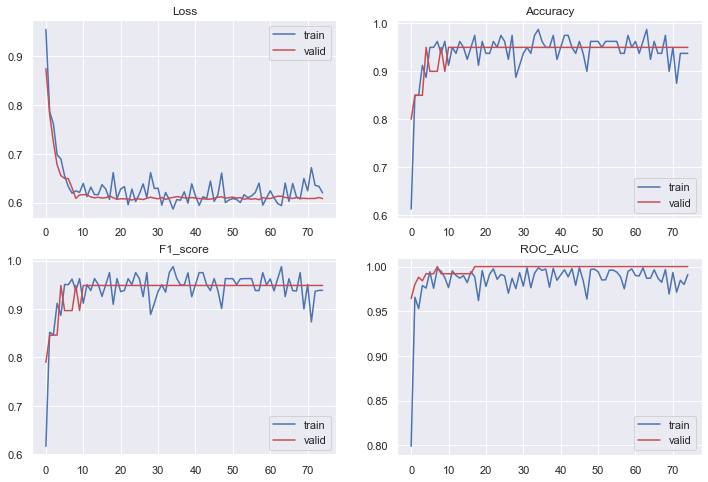

In [24]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)

ax[0,0].plot(train_loss_1, color='b', label='train')
ax[0,0].plot(valid_loss_1, color='r', label='valid')
ax[0,0].legend(loc='best')
ax[0,0].set_title('Loss')

ax[0,1].plot(train_acc_1, color='b', label='train')
ax[0,1].plot(valid_acc_1, color='r', label='valid')
ax[0,1].legend(loc='best')
ax[0,1].set_title('Accuracy')

ax[1,0].plot(train_f1_1, color='b',  label='train')
ax[1,0].plot(valid_f1_1, color='r',  label='valid')
ax[1,0].legend(loc='best')
ax[1,0].set_title('F1_score')

ax[1,1].plot(train_roc_1, color='b', label='train')
ax[1,1].plot(valid_roc_1, color='r', label='valid')
ax[1,1].legend(loc='best')
ax[1,1].set_title('ROC_AUC')

plt.show()

In [35]:
y_pred_train=net.predict_proba(X_train)

In [36]:
from sklearn.metrics import *

In [44]:
fpr = {}
tpr = {}
roc_auc = {}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_train,y_pred_train[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

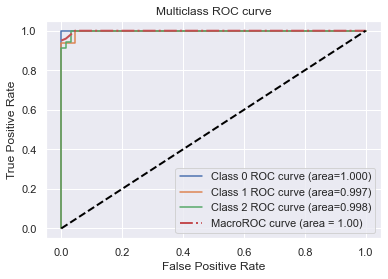

In [56]:
# plotting  
n_classes=3
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class '+str(i)+' ROC curve (area=%0.3f)'%roc_auc[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["macro"],tpr["macro"],linestyle='dashdot',linewidth=2,label="MacroROC curve (area = {0:0.2f})".format(roc_auc["macro"]))    

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dashed')   
plt.title('Multiclass ROC curve');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.legend(loc='best');